In [1]:
import warnings
import numpy as np
import pandas as pd
from collections import Counter

# Sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
df = pd.read_csv("data/telco_dataset.csv")

In [3]:
df.drop(['customerID'],axis=1, inplace=True)

In [4]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

### Pré-Processamento

In [5]:
categorical_cols = [c for c in df.columns if df[c].dtype == 'object' or c == 'SeniorCitizen']
df_categorical = df[categorical_cols].copy()
for col in categorical_cols:
    if df_categorical[col].nunique() == 2:
        df_categorical[col], _ = pd.factorize(df_categorical[col])
    else:
        df_categorical = pd.get_dummies(df_categorical, columns=[col])

In [6]:
df_categorical.head(3)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,0,0,0,0,False,True,False,...,True,False,False,True,False,False,False,False,True,False
1,1,0,1,0,1,1,0,True,False,False,...,True,False,False,False,True,False,False,False,False,True
2,1,0,1,0,1,0,1,True,False,False,...,True,False,False,True,False,False,False,False,False,True


In [7]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
pd.DataFrame(StandardScaler().fit_transform(df[num_cols]),columns=num_cols).head()
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

,tenure,MonthlyCharges,TotalCharges
0,-1.277445,-1.160323,-0.992611
1,0.066327,-0.259629,-0.172165
2,-1.236724,-0.362660,-0.958066
3,0.514251,-0.746535,-0.193672
4,-1.236724,0.197365,-0.938874


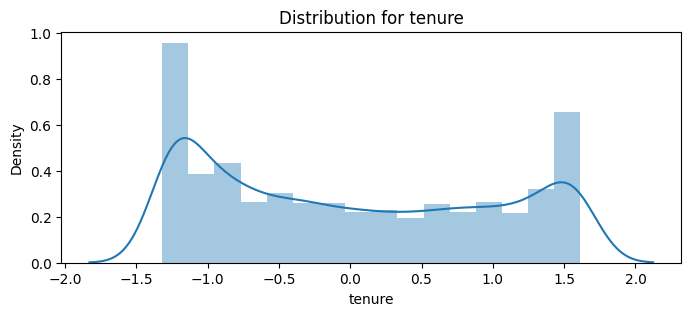

In [8]:
# Verificar que a ditribuição se mantém
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]),columns=num_cols)
plt.figure(figsize=(8,3))
plt.title("Distribution for {}".format("tenure"))
ax = sns.distplot(df_std["tenure"])

### Contruindo o modelo

In [9]:
df_processed = pd.concat([df_std, df_categorical], axis=1)
metrics = ['roc_auc', 'accuracy', 'precision', 'recall']
# https://scikit-learn.org/stable/modules/model_evaluation.html

In [10]:
df_processed.head(3)

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.277445,-1.160323,-0.992611,0,0,0,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
1,0.066327,-0.259629,-0.172165,1,0,1,0,1,1,0,...,True,False,False,False,True,False,False,False,False,True
2,-1.236724,-0.362660,-0.958066,1,0,1,0,1,0,1,...,True,False,False,True,False,False,False,False,False,True


In [11]:
df_processed.shape

(7043, 41)

In [12]:
train, test = train_test_split(df_processed, test_size=0.2, random_state=50)
predictors = [c for c in train.columns if c not in ['customerID', 'Churn']]
clf = LogisticRegression()
clf.fit(train[predictors], train['Churn'])
y_pred = clf.predict(test[predictors]) #0.5
y_prob = clf.predict_proba(test[predictors])[:, 1]
results = list()

In [36]:
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [14]:
for m in metrics:
    if m == 'roc_auc':
        results.append((m, roc_auc_score(test['Churn'], y_prob)))
    else:
        results.append((m, eval("{}_score".format(m))(test['Churn'], y_pred)))

In [15]:
results

[('roc_auc', 0.8398723008812596),
 ('accuracy', 0.7998580553584103),
 ('precision', 0.6360759493670886),
 ('recall', 0.5461956521739131)]

- A precisão mede a quantidade de vezes que o seu modelo acerta em relação ao total de vezes que ele tenta acertar.
- O recall mede a quantidade de vezes que o seu modelo acerta em relação ao total de vezes que ele deveria ter acertado.

In [16]:
# Matrix de confusão
cm = confusion_matrix(test['Churn'], y_pred)
cm

array([[926, 115],
       [167, 201]], dtype=int64)

In [17]:
especificidade = cm[0][0]/(cm[1][0]+cm[0][0])
sensibilidade = cm[1][1]/(cm[1][1]+cm[0][1])
print(sensibilidade, especificidade)

0.8472095150960659 0.6360759493670886


In [18]:
# otimização com Validação Cruzada
clf_cv = LogisticRegressionCV(cv=5, random_state=10)
clf_cv.fit(train[predictors], train['Churn'])
y_pred = clf_cv.predict(test[predictors])
y_prob = clf_cv.predict_proba(test[predictors])[:, 1]
results = list()
for m in metrics:
    if m == 'roc_auc':
        results.append((m, roc_auc_score(test['Churn'], y_prob)))
    else:
        results.append((m, eval("{}_score".format(m))(test['Churn'], y_pred)))
results

[('roc_auc', 0.8398279246543876),
 ('accuracy', 0.8005677785663591),
 ('precision', 0.6389776357827476),
 ('recall', 0.5434782608695652)]

In [19]:
clf.coef_

array([[-1.4272492 ,  0.26709229,  0.66336096,  0.05010496,  0.14382087,
         0.06944087, -0.14397022, -0.4261162 , -0.33677021, -0.33045157,
         0.06321901, -0.09566463, -0.36328918,  0.16371981, -0.16332781,
         0.12144627, -0.16332781, -0.32101564, -0.0102791 , -0.16332781,
        -0.18929027, -0.01189735, -0.16332781, -0.18767203,  0.07652714,
        -0.16332781, -0.27609652, -0.16818456, -0.16332781, -0.03138481,
        -0.1855018 , -0.16332781, -0.01406758,  0.56002528, -0.13834462,
        -0.78457785, -0.12348387, -0.24543391,  0.15287576, -0.14685517]])

In [20]:
c = dict(zip(predictors, abs(clf_cv.coef_[0])))

In [21]:
c

{'tenure': 1.3247756751072672,
 'MonthlyCharges': 0.19089260135072894,
 'TotalCharges': 0.5535666523317002,
 'gender': 0.05009855624704442,
 'SeniorCitizen': 0.14494035023210206,
 'Partner': 0.07413447226537703,
 'Dependents': 0.14384468352690863,
 'PhoneService': 0.2554532908329265,
 'PaperlessBilling': 0.3323935396741058,
 'MultipleLines_No': 0.25475800610823385,
 'MultipleLines_No phone service': 0.2316493465483333,
 'MultipleLines_Yes': 0.0006952847246910186,
 'InternetService_DSL': 0.2814743698623616,
 'InternetService_Fiber optic': 0.32523326840553984,
 'InternetService_No': 0.06756284282776945,
 'OnlineSecurity_No': 0.2356961013104173,
 'OnlineSecurity_No internet service': 0.06756284282776945,
 'OnlineSecurity_Yes': 0.19193720276724016,
 'OnlineBackup_No': 0.10143768762471045,
 'OnlineBackup_No internet service': 0.06756284282776945,
 'OnlineBackup_Yes': 0.05767878908153275,
 'DeviceProtection_No': 0.1009380674227387,
 'DeviceProtection_No internet service': 0.06756284282776945

In [22]:
dict(Counter(c).most_common(10)).keys()

dict_keys(['tenure', 'Contract_Month-to-month', 'Contract_Two year', 'TotalCharges', 'PaperlessBilling', 'InternetService_Fiber optic', 'InternetService_DSL', 'PhoneService', 'MultipleLines_No', 'PaymentMethod_Electronic check'])

In [38]:
results = list()
y_pred_new_threshold = (clf.predict_proba(test[predictors])[:, 1] >= 0.4).astype(int) 
for m in  ['accuracy', 'precision', 'recall']:
    results.append((m, eval("{}_score".format(m))(test['Churn'], y_pred_new_threshold)))
results

[('accuracy', 0.7835344215755855),
 ('precision', 0.5755395683453237),
 ('recall', 0.6521739130434783)]

In [24]:
def logistic_regression(frame, metrics, cv):
    train, test = train_test_split(frame, test_size=0.2, random_state=50)
    predictors = [c for c in train.columns if c not in ['customerID', 'Churn']]
    if cv == False:
        clf = LogisticRegression()
    else:
        clf = LogisticRegressionCV(cv=5, random_state=0)
    clf.fit(train[predictors], train['Churn'])
    y_pred = clf.predict(test[predictors])
    y_prob = clf.predict_proba(test[predictors])[:, 1]
    results = list()

    for m in metrics:
        if m == 'roc_auc':
            results.append((m, roc_auc_score(test['Churn'], y_prob)))
        else:
            results.append((m, eval("{}_score".format(m))(test['Churn'], y_pred)))

    c = dict(zip(predictors, abs(clf.coef_[0])))
    importance = dict(Counter(c).most_common(5)).keys()

    cm = confusion_matrix(test['Churn'], y_pred)
    especificidade = cm[0][0]/(cm[1][0]+cm[0][0])
    sensibilidade = cm[1][1]/(cm[1][1]+cm[0][1])

    return results, sensibilidade, especificidade, importance

In [25]:
logistic_regression(df_processed, metrics, cv = False)

([('roc_auc', 0.8398723008812596),
  ('accuracy', 0.7998580553584103),
  ('precision', 0.6360759493670886),
  ('recall', 0.5461956521739131)],
 0.8472095150960659,
 0.6360759493670886,
 dict_keys(['tenure', 'Contract_Two year', 'TotalCharges', 'Contract_Month-to-month', 'PhoneService']))

### Testando possibilidades

Criando features

In [26]:
df_tmp = df_processed.copy()
df_tmp['charges_difference'] = df_tmp['TotalCharges'] - df_tmp['tenure']*df_tmp['MonthlyCharges']
logistic_regression(df_tmp, metrics, cv = True)

([('roc_auc', 0.8401124545796266),
  ('accuracy', 0.8041163946061036),
  ('precision', 0.6483870967741936),
  ('recall', 0.5461956521739131)],
 0.8480436760691538,
 0.6483870967741936,
 dict_keys(['tenure', 'Contract_Month-to-month', 'Contract_Two year', 'MonthlyCharges', 'InternetService_Fiber optic']))

In [27]:
# Ratio between the tenure multiplied by monthly charges and TotalCharges
df_tmp = df_processed.copy()
df_tmp['charges_ratio'] = df_tmp['tenure']*df_tmp['MonthlyCharges'] / (df_tmp['TotalCharges'] + 1)
logistic_regression(df_tmp, metrics, cv = True)

([('roc_auc', 0.8415324938395355),
  ('accuracy', 0.8019872249822569),
  ('precision', 0.6403785488958991),
  ('recall', 0.5516304347826086)],
 0.8489010989010989,
 0.6403785488958991,
 dict_keys(['tenure', 'Contract_Two year', 'Contract_Month-to-month', 'TotalCharges', 'PaperlessBilling']))

In [28]:
df_tmp = df_processed.copy()
df_tmp['charges_difference'] = df_tmp['TotalCharges'] - df_tmp['tenure']*df_tmp['MonthlyCharges']
df_tmp['charges_ratio'] = df_tmp['tenure']*df_tmp['MonthlyCharges'] / (df_tmp['TotalCharges'] + 1)
logistic_regression(df_tmp, metrics, cv = True)

([('roc_auc', 0.8417126091133107),
  ('accuracy', 0.8034066713981547),
  ('precision', 0.6444444444444445),
  ('recall', 0.5516304347826086)],
 0.8491773308957953,
 0.6444444444444445,
 dict_keys(['tenure', 'Contract_Two year', 'Contract_Month-to-month', 'MonthlyCharges', 'InternetService_Fiber optic']))

Balanceamento

In [29]:
print(
    len(df_processed[df_processed["Churn"]==0]),
    len(df_processed[df_processed["Churn"]==1]),
    df_processed.shape
)

5174 1869 (7043, 41)


In [30]:
df_processed_no = df_processed[df_processed["Churn"]==0].sample(n=len(df_processed[df_processed["Churn"]==1]))
df_processed_yes = df_processed[df_processed["Churn"]==1]

In [31]:
df_processed_balanced = pd.concat([df_processed_no, df_processed_yes])

In [32]:
df_processed_balanced.shape

(3738, 41)

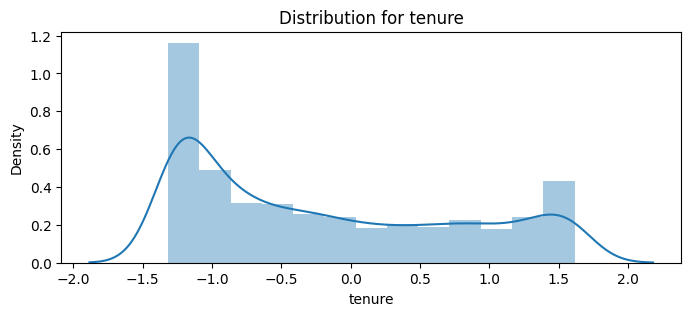

In [33]:
plt.figure(figsize=(8,3))
plt.title("Distribution for {}".format("tenure"))
ax = sns.distplot(df_processed_balanced["tenure"])

In [34]:
logistic_regression(df_processed_balanced, metrics, cv = True)

([('roc_auc', 0.8575310919922476),
  ('accuracy', 0.7820855614973262),
  ('precision', 0.7823834196891192),
  ('recall', 0.7926509186351706)],
 0.7817679558011049,
 0.7823834196891192,
 dict_keys(['tenure', 'TotalCharges', 'Contract_Two year', 'Contract_Month-to-month', 'InternetService_Fiber optic']))

In [35]:
df_tmp = df_processed_balanced.copy()
df_tmp['charges_difference'] = df_tmp['TotalCharges'] - df_tmp['tenure']*df_tmp['MonthlyCharges']
df_tmp['charges_ratio'] = df_tmp['tenure']*df_tmp['MonthlyCharges'] / (df_tmp['TotalCharges'] + 1)
logistic_regression(df_tmp, metrics, cv = True)

([('roc_auc', 0.8616790748567873),
  ('accuracy', 0.7927807486631016),
  ('precision', 0.7825),
  ('recall', 0.821522309711286)],
 0.8045977011494253,
 0.7825,
 dict_keys(['tenure', 'Contract_Two year', 'Contract_Month-to-month', 'TotalCharges', 'InternetService_Fiber optic']))